### Chatbot using LangGraph with Tools

In [52]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_core.messages import HumanMessage, SystemMessage
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = 'ReAct-Agent'


In [53]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv, description="Query arxiv papers")
print(arxiv.name)

arxiv


In [54]:
arxiv.invoke("Attention all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [55]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki, description="Query the wiki")
print(wiki.name)

wikipedia


In [56]:
wiki.invoke("Who is Nikola Tesla the Serbian-American engineer?")

'Page: Nikola Tesla\nSummary: Nikola Tesla (10 July 1856 – 7 January 1943) was a Serbian-American engineer, futurist, and inventor. He is known for his contributions to the design of the modern alternating current (AC) electricity supply system.\nBorn and raised in the Austrian Empire, Tesla first studied engineering and physics in the 1870s without receiving a degree. He then gained practical experience in the early 1880s working in telephony and at Continental Edison in the new electric power ind'

In [57]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()

In [58]:
tavily.invoke("What is the current AI News?")

[{'title': 'The latest AI news we announced in June - Google Blog',
  'url': 'https://blog.google/technology/ai/google-ai-updates-june-2025/',
  'content': '# The latest AI news we announced in June\n\nJul 02, 2025\n\nHere’s a recap of some of our biggest AI updates from June, including more ways to search with AI Mode, a new way to share your NotebookLM notebooks publicly, and a new AI to help researchers better understand the human genome.\n\nSuperG\n\n## Basic explainer [...] Search finds new voice, and photos bright,  \nWhile Chromebooks gain AI\'s keenest edge,  \nAnd learning\'s path is filled with light.\n\nGenomes unlock, from knowledge pledge,  \nAnd robots learn, with vision clear,  \nWhile cancer\'s foe meets AI\'s siege.\n\nFrom Google\'s labs, new AI doth spring,  \nWith Gemini\'s models taking flight,  \nAnd tools for coders, joy to bring.\n\nSearch finds new voice, and photos bright,  \nWhile Chromebooks gain AI\'s keenest edge,  \nAnd learning\'s path is filled with lig

In [59]:
## custom tools
def multiply(a:int, b:int)-> int:
    """ Multipy a and b
    Args: you will get two numbers
    """
    return a*b

In [60]:
#combine all the tools (bind)
tools = [wiki, arxiv, tavily, multiply]

In [61]:
# Initiilize my LLM
from langchain_groq import ChatGroq
llm = ChatGroq(model="qwen/qwen3-32b")
llm_bind_tools = llm.bind_tools(tools=tools)


In [62]:
llm_bind_tools.invoke("What is latest AI news?")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for the latest news in AI. Let me see which tool I should use here. The available tools are Wikipedia, arXiv, Tavily Search, and a multiply function. The multiply function is for math operations, so that\'s not relevant here. Wikipedia might have general information, but it\'s not the best for the latest news. arXiv is for academic papers, which could be useful for recent research but maybe not the most recent news. Tavily Search is a search tool, so using that with a query like "latest AI news" would probably give the most up-to-date results. I should go with Tavily Search to fetch the latest news articles on AI.\n', 'tool_calls': [{'id': 'zbcd33k9z', 'function': {'arguments': '{"query":"latest AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 176, 'prompt_tokens': 322, 'total_tokens': 498, 'completion_time': 0.38275468

In [63]:
tool_call = llm_bind_tools.invoke("What is latest AI news?")
tool_call.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'latest AI news'},
  'id': '0yfzj2k8e',
  'type': 'tool_call'}]

In [64]:
# State session
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

class State(TypedDict):
    messages: Annotated[list[AnyMessage],add_messages]

## node creation
def llm_calling_tool(state:State):
    return {'messages': [llm_bind_tools.invoke(state['messages'])]}

## build graph
builder = StateGraph(State)
builder.add_node('llm_calling_tool',llm_calling_tool)
builder.add_node('tools', ToolNode(tools))

builder.add_edge(START, 'llm_calling_tool')
builder.add_conditional_edges("llm_calling_tool", tools_condition) # either tools or end
builder.add_edge('tools', 'llm_calling_tool')


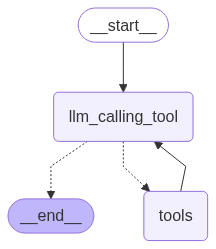

In [65]:
graph  = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [45]:

messages = graph.invoke({"messages": HumanMessage(content='1706.03762')})
for i in messages['messages']:
    i.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (d3cfv6rxy)
 Call ID: d3cfv6rxy
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base
================================== Ai Message ==================================

The paper "Attention Is All You Need" (arXiv ID: 1706.03762) is a f

In [46]:
messages = graph.invoke({"messages": HumanMessage(content='Provide me the latest AI news')})
for i in messages['messages']:
    i.pretty_print()

================================ Human Message =================================

Provide me the latest AI news
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (kz9a2bw6b)
 Call ID: kz9a2bw6b
  Args:
    query: latest AI news
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "The latest AI news we announced in June - Google Blog", "url": "https://blog.google/technology/ai/google-ai-updates-june-2025/", "content": "# The latest AI news we announced in June\n\nJul 02, 2025\n\nHere’s a recap of some of our biggest AI updates from June, including more ways to search with AI Mode, a new way to share your NotebookLM notebooks publicly, and a new AI to help researchers better understand the human genome.\n\nSuperG\n\n## Basic explainer [...] a text card reading \"AI to revolutionize scientific discovery\"\n\nWe introduced AlphaGenome: AI to bett

In [67]:

messages = graph.invoke({"messages": HumanMessage(content='Ai news today and also multiply 5 and 4')})
for i in messages['messages']:
    i.pretty_print()

================================ Human Message =================================

Ai news today and also multiply 5 and 4
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (gw7bgasnn)
 Call ID: gw7bgasnn
  Args:
    query: AI news today
  multiply (kzeb8wmgm)
 Call ID: kzeb8wmgm
  Args:
    a: 5
    b: 4
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI News & Artificial Intelligence | TechCrunch", "url": "https://techcrunch.com/category/artificial-intelligence/", "content": "Contact Us\n\n# AI\n\nNews coverage on artificial intelligence and machine learning tech, the companies building them, and the ethical issues AI raises today. This encompasses generative AI, including large language models, text-to-image and text-to-video models; speech recognition and generation; and predictive analytics.\n\n### \n\nAnthropic Claude logo on mobile

## Adding memeory

In [68]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [75]:
config = {"configurable":{"thread_id":"4"}}
response = graph.invoke({"messages":"my name is vai"}, config = config)

response

{'messages': [HumanMessage(content='my name is vai', additional_kwargs={}, response_metadata={}, id='e954302b-83e3-4faf-ac6a-3661e5353502'),
  AIMessage(content='Hello, Vai! How can I assist you today?', additional_kwargs={'reasoning_content': 'Okay, the user said, "my name is vai." Let me think about how to respond. First, I need to acknowledge their introduction. Since they provided their name, a simple and friendly response would be best. I don\'t need to use any of the tools here because there\'s no query or request for information. The user is just introducing themselves, so there\'s no need to call functions like wikipedia, arxiv, or tavily_search. The multiply function is also irrelevant here. I should just greet them back and offer assistance. Something like, "Hello, Vai! How can I assist you today?" That should cover it without needing any tool calls.\n'}, response_metadata={'token_usage': {'completion_tokens': 152, 'prompt_tokens': 320, 'total_tokens': 472, 'completion_time':

In [76]:
response = graph.invoke({"messages":"what is my name?"}, config = config)

response

{'messages': [HumanMessage(content='my name is vai', additional_kwargs={}, response_metadata={}, id='e954302b-83e3-4faf-ac6a-3661e5353502'),
  AIMessage(content='Hello, Vai! How can I assist you today?', additional_kwargs={'reasoning_content': 'Okay, the user said, "my name is vai." Let me think about how to respond. First, I need to acknowledge their introduction. Since they provided their name, a simple and friendly response would be best. I don\'t need to use any of the tools here because there\'s no query or request for information. The user is just introducing themselves, so there\'s no need to call functions like wikipedia, arxiv, or tavily_search. The multiply function is also irrelevant here. I should just greet them back and offer assistance. Something like, "Hello, Vai! How can I assist you today?" That should cover it without needing any tool calls.\n'}, response_metadata={'token_usage': {'completion_tokens': 152, 'prompt_tokens': 320, 'total_tokens': 472, 'completion_time':